# Deep Neural Network for Smile Detection
    Handle class imbalance by scaling the logits

Accuaracy on test set =  0.869351

Classification report : 

             precision    recall  f1-score   support

         negatives       0.92      0.91      0.91      1937
  
         positives       0.75      0.79      0.77       696

        avg / total       0.88      0.88      0.88      2633

##  Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from time import time
import os
import tensorflow as tf
from time import time

from pylab import rcParams
rcParams['figure.figsize'] = 12,10

import cv2

##  Fetch dataset

In [2]:
#All images provided to the classifier should have fixed and equal sizes
dim = (64, 64)

def fetch_category_images(path_to_subject, subject_number):
    
    X = np.array([])
    index = 0
    for subject_img in os.listdir(path_to_subject): #for each image in this subject's folder
        img_path = os.path.join(path_to_subject, subject_img)
        if img_path.endswith(".pgm") or img_path.endswith(".png") or img_path.endswith(".jpg") or img_path.endswith(".jpeg"):
            #Read image, convert it to grayscale and resize every image to a fixed size  
            img = cv2.resize(cv2.imread(img_path, 0), dim, interpolation = cv2.INTER_AREA) 
            
            #img_data = img.ravel()  #Flatten each image, so that each sample is a 1D vector
            img_data = img[np.newaxis, :, :]
            X = img_data if not X.shape[0] else np.vstack((X, img_data))
            index += 1

    y = np.empty(index, dtype = int) #index = total no. of samples
    y.fill(subject_number)  #add labels
    return X, y

def fetch_data(dataset_path):

    # Get a the list of folder names in the path to dataset
    labels_list = [d for d in os.listdir(dataset_path) if "." not in str(d)]
    X = np.empty([0, dim[0], dim[1]])
    y = np.empty([0])

    for i in range(0, len(labels_list)):  #for each person
        subject = str(labels_list[i])  #person i in list of ppl
        path_to_subject = os.path.join(dataset_path, subject) #full path to this person's directory
        
        #Read all images in this folder (all images of this person)
        X_, y_ = fetch_category_images(path_to_subject, i)
        X = np.concatenate((X, X_), axis=0)
        y = np.append(y, y_)
        print("Class {}: '{}', {} images loaded".format(i, labels_list[i], X_.shape[0]))

    return X, y, labels_list

# Load training data 
dataset_path = "Smile_dataset/"
X, y, labels_list  = fetch_data(dataset_path)

Class 0: 'negatives', 9475 images loaded
Class 1: 'positives', 3690 images loaded


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

n_classes = len(np.unique(y))
print("Dataset consists of {} samples and  {} classes".format(X.shape[0], n_classes))
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.reshape(y, (-1, 1))).toarray()

print("Data: {} and one hot encoded labels: {}".format(X.shape, labels.shape))                                                                                           
print(" ")
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20, random_state=42)
print("Training data {}, test data {}".format(X_train.shape,X_test.shape))

Dataset consists of 13165 samples and  2 classes
Data: (13165, 64, 64) and one hot encoded labels: (13165, 2)
 
Training data (10532, 64, 64), test data (2633, 64, 64)


## Reduce dimensionality

In [4]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95, whiten=True).fit(X_train)  #preserve 95% of variance
n_comp = pca.n_components_
print("PCA reduced dimensionality from {} to {}".format(X_train.shape[1], n_comp))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("New training and test data", X_train_pca.shape, "and", X_test_pca.shape)

PCA reduced dimensionality from 4096 to 176
New training and test data (10532, 176) and (2633, 176)


##  Handle data imbalance: Scale logits

Solution from here: https://stackoverflow.com/questions/35155655/loss-function-for-class-imbalanced-binary-classifier-in-tensor-flow

more explanation : https://www.quora.com/How-do-I-implement-cost-sensitive-learning-in-TensorFlow-to-penalize-for-misclassification-on-minority-classes-data-has-a-class-imbalance-problem

In [26]:
#Compute class weight
samples_per_class = labels.sum(axis=0)
class1, n_class1 = labels_list[0], samples_per_class[0]
class2, n_class2 = labels_list[1], samples_per_class[1]
print("Samples per class: {} =  {} and {} = {}".format(class1, n_class1, class2, n_class2))

total_samples = n_class1 + n_class2 # 13,165

# class_weight = list((n_class1, n_class2)/total_samples)
# print("Total samples in dataset = ".format(total_samples))

# print("Class weight computed:", class_weight)

ratio = n_class2 / (n_class1 + n_class2)
print("Ratio computed", ratio)
class_weight = [ratio, 1.0 - ratio]

# weight vector for classes0 and 1:

# [ 1 - n_class0 / total , 1 - n_class1 / total]

tf_class_weight = tf.constant(class_weight)  #[0.28028864413216864, 0.7197113558678314]
print("Class weight computed = ", class_weight)

Samples per class: negatives =  9475.0 and positives = 3690.0
Ratio computed 0.280288644132
Class weight computed =  [0.28028864413216864, 0.71971135586783141]


### We have only 3690 positives, as compared to 9475 negatives. Notice that the weights are computed in such a way, that the weight for the minor/  1 or positive class is greater - this tells our model to pay special attention to class 1.

In [34]:
# tf.reset_default_graph()

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64

hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, kernel_initializer = xavier_init)

hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, kernel_initializer = xavier_init)

logits = tf.layers.dense(hidden2, n_classes)
weighted_logits = tf.multiply(logits, class_weight)

prediction = tf.nn.softmax(weighted_logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = weighted_logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./dnn_imbalance3"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.984375, train loss = 0.10318525992551894
Validation loss: 0.3248581110231075, minimum loss: 0.3248581110231075, validation accuracy: 0.8564375042915344
 
EPOCH 1
Train accuracy = 0.9375, train loss = 0.1646799733038905
Validation loss: 0.3099255307399318, minimum loss: 0.3099255307399318, validation accuracy: 0.8693505525588989
 
EPOCH 2
Train accuracy = 0.96875, train loss = 0.09386846300202464
Validation loss: 0.31161778191946654, minimum loss: 0.3099255307399318, validation accuracy: 0.8784656524658203
 
EPOCH 3
Train accuracy = 1.0, train loss = 0.03484253799170645
Validation loss: 0.3301697311439016, minimum loss: 0.3099255307399318, validation accuracy: 0.8784656524658203
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.038797502613314605
Validation loss: 0.391101528659476, minimum loss: 0.3099255307399318, validation accuracy: 0.8720090985298157
 
EPOCH 5
Train accuracy = 0.984375, train loss = 0.042125821850776485
Validation loss: 0.397389412079055

##  Evaluate the model

In [35]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.869351
Classification report : 
             precision    recall  f1-score   support

  negatives       0.92      0.91      0.91      1937
  positives       0.75      0.79      0.77       696

avg / total       0.88      0.88      0.88      2633



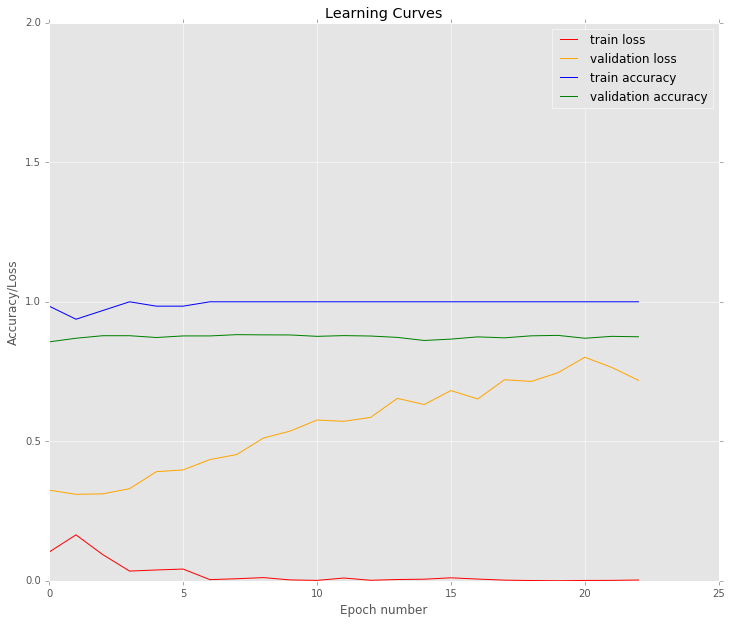

In [36]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()